In [1]:
import numpy as np
import pandas as pd
import os

import scipy.io as scio
from scipy import stats
import base_functions as bf
import conn_base_functions as cbf
import pickle

from nilearn import image, plotting, connectome
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# plt.rcParams["font.family"] = "Times New Roman"

%matplotlib inline

/tmp/ipykernel_92827/3613555308.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
D = pickle.load(open('./data/D1Morning_sig_patterns.pkl', 'rb'))
pvals_fdr = D['pvals_fdr']
patterns = D['boot_patterns']
patterns_mtx = connectome.vec_to_sym_matrix(patterns.reshape(-1), diagonal=np.zeros(442))

D = pickle.load(open('./data/D1Morning_partial_sig_patterns.pkl', 'rb'))
part_pvals_fdr = D['pvals_fdr']
part_patterns = D['boot_patterns']
part_patterns_mtx = connectome.vec_to_sym_matrix(part_patterns.reshape(-1), diagonal=np.zeros(442))

D = pickle.load(open('./data/D2Morning_sig_patterns.pkl', 'rb'))

rec_pvals_fdr = D['pvals_fdr']
rec_patterns = D['boot_patterns']
rec_patterns_mtx = connectome.vec_to_sym_matrix(rec_patterns.reshape(-1), diagonal=np.zeros(442))

In [4]:
rnfile = './data/whole_brain_mask_Sch7net400_subcortex_cerebellum.csv'
masker_info = pd.read_csv(rnfile)
network_name = masker_info['network_name'].to_list()
network_name = network_name[:442]

net_list = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Subcortex', 'Cerebellum']#ignore 'Cerebellum'
reorder_idx = []
for inet,net in enumerate(net_list):
    idx = [i for i,n in enumerate(network_name) if n==net]
    if net=='Subcortex':# For subcortex, the regions started with right hemi, reorder it
        idx = idx[16:] + idx[:16]
    reorder_idx.extend(idx)
    
coord_reg = pd.read_csv('./data/Sch7net400_subcortex_cerebellum_COG.txt', header=None, sep=' ').to_numpy()[:432]

tcolor = pd.read_csv('./data/colormap_8network.txt', header=None, sep=' ').to_numpy() / 255
net_colors = [tcolor[i] for i in range(tcolor.shape[0])]
net_colors[-1], net_colors[-2] = net_colors[-2], net_colors[-1]#switch order of VIS and SUB
net_colors.append(np.array([78/255, 240/255, 199/255]))
net_colors[3] = np.array([252/255,221/255,195/255])#change color for LIM, make it more visiable

net_abbre = ['CON', 'DMN', 'DAN', 'LIM', 'VAN', 'SMN', 'VIS', 'SUB', 'CER']#
network_list = ['Cont','Default','DorsAttn','Limbic','SalVentAttn','SomMot','Vis','Subcortex','Cerebellum']

network_abbre = [net_abbre[network_list.index(n)] for n in network_name]

region_colors = [net_colors[net_abbre.index(n)] for n in network_abbre]

In [5]:
def get_net_values(regional_values, regional_netnames, net_list):
    mean_vals = np.zeros(len(net_list))
    std_vals = np.zeros(len(net_list))
    sem_vals = np.zeros(len(net_list))
    for inet,net in enumerate(net_list):
        idx = [i for i,n in enumerate(regional_netnames) if n==net]
        mean_vals[inet] = np.mean(regional_values[idx])
        std_vals[inet] = np.std(regional_values[idx])
        sem_vals[inet] = np.std(regional_values[idx])/np.sqrt(len(idx))
    return mean_vals, std_vals, sem_vals
    
def plot_radar_with_scatter(regional_values_list, regional_netnames, net_list, net_colors, color_list, sig_marker):
    fig, axs = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)
    axs.set_axis_off()
    
    titles = net_list
    rect = [0., 0., 1, 1]
    n = len(net_list)

    angles = [a if a <=360. else a - 360. for a in np.arange(90, 90+360, 360.0/n)] 

    ax2 = fig.add_axes([0.0, 0.0, 1, 1], label="pie axes", zorder=0)
    ax2.spines['bottom'].set_visible(False)
    sizes = 100*np.ones(n)/n
    d = ax2.pie(sizes, radius=1.5, autopct='',startangle=70, labeldistance=1.0, wedgeprops=dict(edgecolor='black', linewidth=2), colors=net_colors)

    ax = fig.add_axes(rect, projection="polar", label="axes%d" % 0)
    
    ax.set_thetagrids(angles, labels=[], fontsize=12, weight="bold")
    
    for i in range(n):
        ax.text(np.radians(angles[i]),3.25,titles[i]+'\n'+sig_marker[i], fontsize=12, ha='center', va='center', color='black')

    # add ticks
    ax.set_ylim(-0.5, 3)
    tick_label = list(np.arange(0,3,0.5))
    ax.set_rgrids(np.arange(0,3,0.5), labels=tick_label, angle=angles[-1]-25, fontsize=10)

    for iv, regional_values in enumerate(regional_values_list):
        mean_vals, std_vals, sem_vals = get_net_values(regional_values, regional_netnames, net_list)
        svalues0 = mean_vals - std_vals
        svalues1 = mean_vals + std_vals
        
        angle = np.deg2rad(np.r_[angles, angles[0]])
        values = np.r_[mean_vals, mean_vals[0]]
        svalues0 = np.r_[svalues0, svalues0[0]]
        svalues1 = np.r_[svalues1, svalues1[0]]
        
        ax.plot(angle, values, color=color_list[iv], linewidth=3)

        gitter = [-0.2, 0.2]
        for ia in range(len(angle)):
            if ia==len(angle)-1:
                continue
            idx = [i for i,n in enumerate(network_abbre) if n==net_list[ia]]
            val = regional_values[idx]
            # if iv==0:
            #     ang = angle[ia] + 0.15*np.random.rand(len(val))
            # else:
            #     ang = angle[ia] - 0.15*np.random.rand(len(val))
            ang = angle[ia] + gitter[iv]*np.random.rand(len(val))
            ax.scatter(ang, val, c=color_list[iv], s=5 + 30*val**2, alpha=0.4, edgecolors=None, linewidths=0)

    return fig

/tmp/ipykernel_92827/4005994578.py:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(ang, val, c=color_list[iv], s=5 + 30*val**2, alpha=0.4, edgecolors=None, linewidths=0)


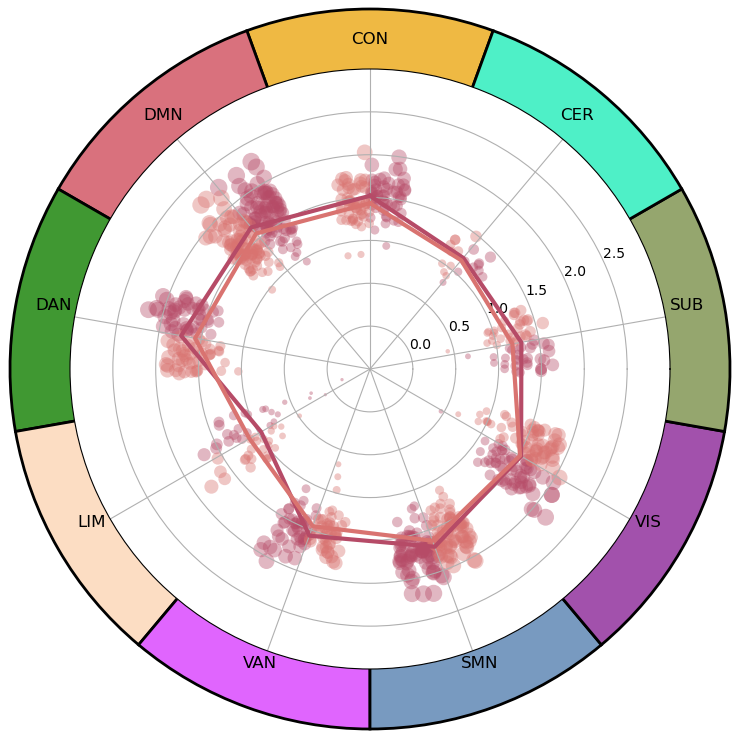

In [6]:
import seaborn as sns
deep_colors = sns.color_palette("deep", as_cmap=True)
use_colors = [deep_colors[3], deep_colors[4]]

# pos_use_colors = [[182/255,75/255,103/255], [220/255,136/255,88/255]]#[184/255,159/255,75/255],[236/255,188/255,157/255]
# neg_use_colors = [[50/255,128/255,140/255], [135/255,194/255,126/255]]

pos_use_colors = [[182/255,75/255,103/255], [217/255,115/255,112/255]]#[184/255,159/255,75/255],[236/255,188/255,157/255]
neg_use_colors = [[50/255,128/255,140/255], [156/255,181/255,165/255]]#[125/255,146/255,189/255]

tpatterns_mtx = patterns_mtx.copy()
tpatterns_mtx[tpatterns_mtx<0] = np.nan
tpart_patterns_mtx = part_patterns_mtx.copy()
tpart_patterns_mtx[tpart_patterns_mtx<0] = np.nan
trec_patterns_mtx = rec_patterns_mtx.copy()
trec_patterns_mtx[trec_patterns_mtx<0] = np.nan

pA = np.nansum(np.abs(tpatterns_mtx), axis=1)
pB = np.nansum(np.abs(tpart_patterns_mtx), axis=1)
pC = np.nansum(np.abs(trec_patterns_mtx), axis=1)


fig = plot_radar_with_scatter([np.log(pA), np.log(pC)], # change pC to pB for comparing with partial deprivation
                              network_abbre, net_abbre, net_colors, pos_use_colors, len(net_abbre)*[''])
# fig.savefig(f'./results/circle_pattern_change_vs_recover_pos.pdf', bbox_inches='tight')

/tmp/ipykernel_92827/4005994578.py:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(ang, val, c=color_list[iv], s=5 + 30*val**2, alpha=0.4, edgecolors=None, linewidths=0)


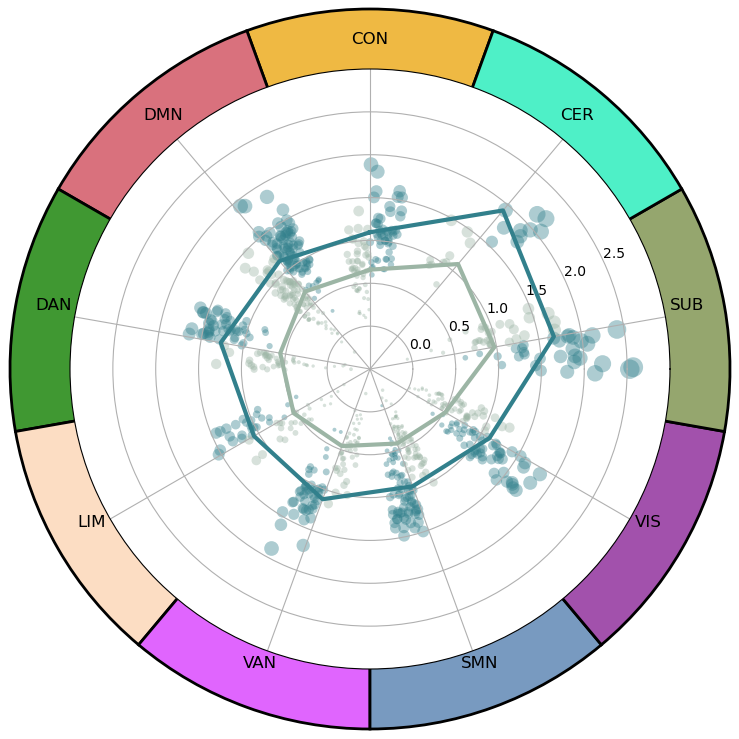

In [7]:
tpatterns_mtx = patterns_mtx.copy()
tpatterns_mtx[tpatterns_mtx>0] = np.nan
tpart_patterns_mtx = part_patterns_mtx.copy()
tpart_patterns_mtx[tpart_patterns_mtx>0] = np.nan
trec_patterns_mtx = rec_patterns_mtx.copy()
trec_patterns_mtx[trec_patterns_mtx>0] = np.nan

nA = np.nansum(np.abs(tpatterns_mtx), axis=1)
nB = np.nansum(np.abs(tpart_patterns_mtx), axis=1)
nC = np.nansum(np.abs(trec_patterns_mtx), axis=1)


fig = plot_radar_with_scatter([np.log(nA), np.log(nC)], 
                              network_abbre, net_abbre, net_colors, neg_use_colors, len(net_abbre)*[''])
# fig.savefig(f'./results/circle_pattern_change_vs_recover_neg.pdf', bbox_inches='tight')

/tmp/ipykernel_92827/229172046.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=net_df, x='net', y='vals', boxprops={'alpha':0.8}, fliersize=0, showcaps=False, order=net_order, palette=net_order_colors)


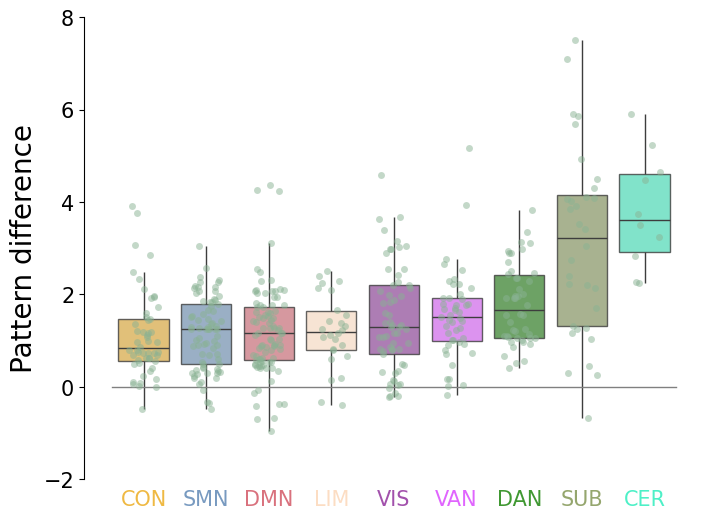

In [8]:
import seaborn as sns

tick_size = 15
xylabel_size = 20


# diff_vals = np.log(nA) - np.log(nC)
diff_vals = nA - nC
net_df = pd.DataFrame({'vals':diff_vals, 'net':network_abbre})

m, _, _ = get_net_values(diff_vals, network_abbre, net_abbre)
sort_idx = np.argsort(m)
net_order = [net_abbre[i] for i in sort_idx]
net_order_colors = [net_colors[i] for i in sort_idx]

tpvals_fdr = np.ones(len(network_abbre))
sig_idx = np.where(tpvals_fdr<=0.05)[0]
sig_net_df = net_df.iloc[sig_idx]
nosig_idx = np.where(tpvals_fdr>0.05)[0]
nosig_net_df = net_df.iloc[nosig_idx]

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(data=net_df, x='net', y='vals', boxprops={'alpha':0.8}, fliersize=0, showcaps=False, order=net_order, palette=net_order_colors)
ax = sns.stripplot(data=sig_net_df, x='net', y='vals', dodge=True, ax=ax, jitter=0.25, order=net_order, palette=net_order_colors, size=8)
ax = sns.stripplot(data=nosig_net_df, x='net', y='vals', dodge=True, ax=ax, jitter=0.25, order=net_order, color=(137/255,178/255,147/255), size=5, alpha=0.5)# pos: (208/255,144/255,143/255), neg:(137/255,178/255,147/255)
# ax = sns.stripplot(data=nosig_net_df, x='net', y='vals', dodge=True, ax=ax, jitter=0.25, order=net_order, palette=net_order_colors, size=5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='x', width=0)

# ymin = np.round(diff_vals.min())
# ymax = np.ceil(diff_vals.max())
ymin, ymax = -2, 8
ax.set_ylim((ymin, ymax));
ax.set_yticks(np.arange(ymin, ymax+0.1, 2));
ax.plot([-0.5,8.5], [0,0], color='gray', linewidth=1)
ax.set_xlabel('')
ax.set_ylabel('Pattern difference', fontsize=xylabel_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)

for xtick,clr in zip(ax.get_xticklabels(), net_order_colors):
    xtick.set_color(clr)
    
# svfile = f'./results/bar_weights_vs_recover_neg.pdf'
# fig.savefig(svfile, bbox_inches='tight')